In [27]:
# import numpy as np
# import pandas as pd
# import os, math, sys
# import glob, itertools
# import argparse, random

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.autograd import Variable
# from torchvision.models import vgg19
# import torchvision.transforms as transforms
# from torch.utils.data import DataLoader, Dataset
# from torchvision.utils import save_image, make_grid

# import plotly
# import plotly.express as px
# import plotly.graph_objects as go
# import matplotlib.pyplot as plt

# from PIL import Image
# from tqdm import tqdm_notebook as tqdm
# from sklearn.model_selection import train_test_split

# random.seed(42)
# import warnings
# warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

random.seed(42)
import warnings
warnings.filterwarnings("ignore")


In [28]:
# Load pretrained models
load_pretrained_models = True
# Number of epochs of training
n_epochs = 1
# Name of the dataset
dataset_path = "../input/satellite-image-256x256/"
# Size of the batches
batch_size = 16
# Adam: learning rate
lr = 0.00008
# Adam: decay of first-order momentum of gradient
b1 = 0.5
# Adam: decay of second-order momentum of gradient
b2 = 0.999
# Epoch from which to start LR decay
decay_epoch = 100
# Number of CPU threads to use during batch generation
n_cpu = 8
# High res. image height
hr_height = 256
# High res. image width
hr_width = 256
# Number of image channels
channels = 3

os.makedirs("output_images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

cuda = torch.cuda.is_available()
hr_shape = (hr_height, hr_width)

# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])


In [29]:
def apply_tone_mapping(image):
    img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return img_output

def skew_correction(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    corrected_image = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return corrected_image

def preprocess_image(image):
    image = apply_tone_mapping(image)
    image = skew_correction(image)
    return image

# Apply this preprocessing before feeding the image into the model


### Define Dataset Class

In [30]:
# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

class ImageDataset(Dataset):
    def __init__(self, files, hr_shape):
        hr_height, hr_width = hr_shape
        # Transforms for low resolution images and high resolution images
        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height // 4, hr_height // 4), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height, hr_height), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
        self.files = files
    
    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        img_lr = self.lr_transform(img)
        img_hr = self.hr_transform(img)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.files)

### Get Train/Test Dataloaders

In [31]:
import glob
from sklearn.model_selection import train_test_split

# Set the correct path to your images directory
dataset_path = "input_images"  # Replace with your actual path

# Get a list of all image files in the directory
image_paths = sorted(glob.glob(dataset_path + "/*.*"))

# Ensure there are images in the directory
if not image_paths:
    raise ValueError("No images found in the specified dataset path. Please check the path.")

# Split the images into training and testing sets
train_paths, test_paths = train_test_split(image_paths, test_size=0.02, random_state=42)
train_dataloader = DataLoader(ImageDataset(train_paths, hr_shape=hr_shape), batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(ImageDataset(test_paths, hr_shape=hr_shape), batch_size=int(batch_size*0.75), shuffle=True, num_workers=0)




### Define Model Classes

In [32]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(2):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

### Train Super Resolution GAN (SRGAN)

In [33]:
# Initialize generator and discriminator
generator = GeneratorResNet()
discriminator = Discriminator(input_shape=(channels, *hr_shape))
feature_extractor = FeatureExtractor()

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()

# Move models and losses to GPU if available
if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()

# Load pretrained models
if load_pretrained_models:
    generator.load_state_dict(torch.load("saved_models/generator.pth", map_location=torch.device('cpu')))
    discriminator.load_state_dict(torch.load("saved_models/discriminator.pth", map_location=torch.device('cpu')))

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor


In [34]:
import torch

# Check if CUDA is available
cuda = torch.cuda.is_available()
if cuda:
    device=torch.device('cuda')
else:
    device=torch.device('cpu')


In [35]:
import cv2
import numpy as np

def tone_mapping(img):
    # Convert from channel-first (C, H, W) to channel-last (H, W, C) if necessary
    if img.shape[0] == 3:  # Channel-first format
        img = np.transpose(img, (1, 2, 0))
    
    # Ensure the image has 3 channels (convert grayscale to RGB if needed)
    if img.ndim == 2 or img.shape[-1] == 1:  # Grayscale or single-channel image
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[-1] != 3:  # Image does not have 3 channels
        raise ValueError("Image must have 3 channels for tone mapping.")
    
    # Ensure the image is in float32 format
    img = img.astype(np.float32) / 255.0

    # Create a Reinhard tone mapper
    tonemap = cv2.createTonemapReinhard(gamma=2.2, intensity=0, light_adapt=0, color_adapt=0)
    ldr = tonemap.process(img)
    
    return (ldr * 255).astype(np.uint8)





In [36]:
import cv2
import numpy as np

def skew_correction(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Invert the image to make the text white on black
    gray = cv2.bitwise_not(gray)
    
    # Convert the grayscale image to uint8 (8-bit single channel)
    gray = np.uint8(gray)
    
    # Apply thresholding (binary + OTSU)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # Calculate the coordinates of the contours
    coords = np.column_stack(np.where(binary > 0))
    
    # Get the minimum area bounding box that encloses the white pixels
    angle = cv2.minAreaRect(coords)[-1]
    
    # Correct the angle
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    
    # Get the image center
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    
    # Compute the rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Perform the affine transformation (rotate the image)
    corrected_image = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    return corrected_image



SSIM Results: [0.09518344939125171]
PSNR Results: [27.900007990354304]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Inception Score - Mean: nan, Std: nan
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
FID Score: 698.4482398778828


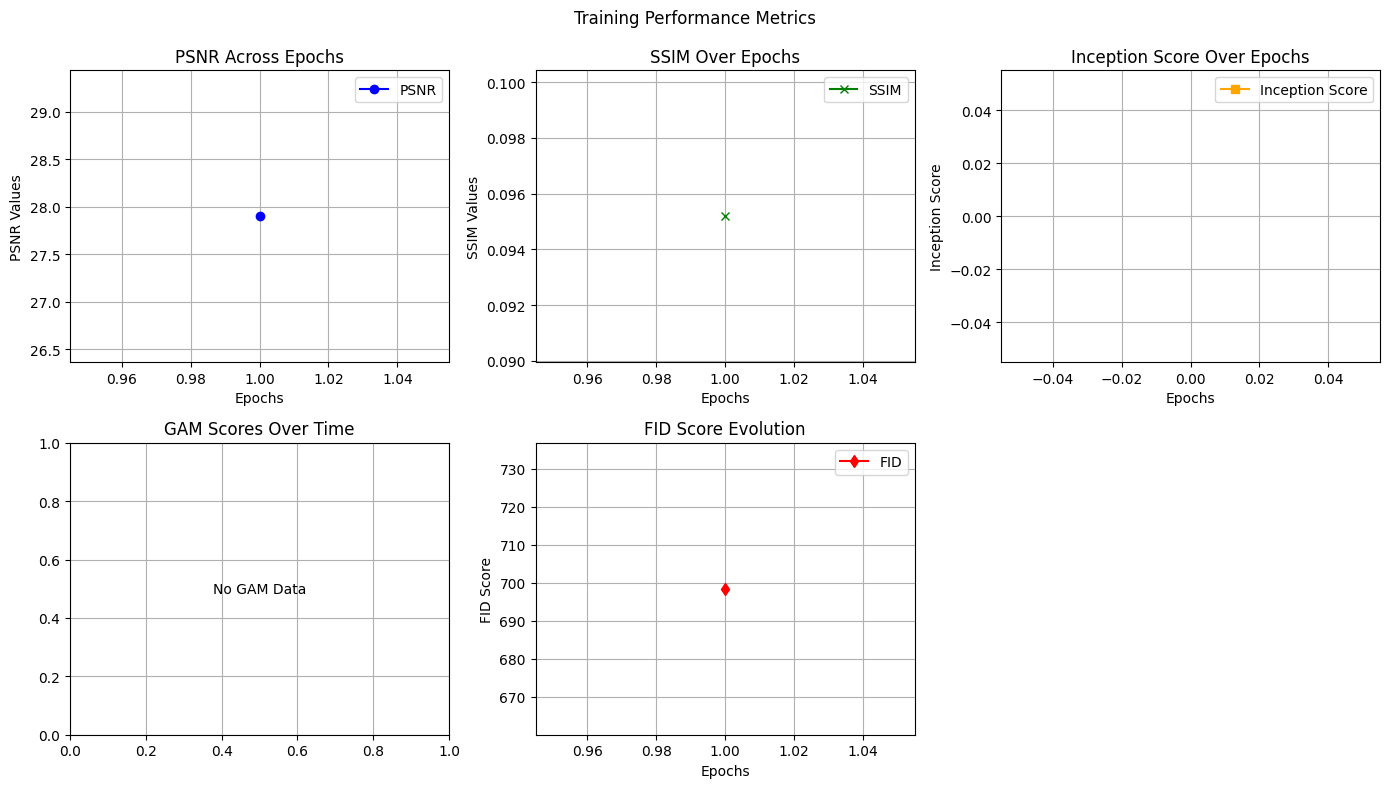

In [41]:

# import os
# from PIL import Image
# import numpy as np
# from skimage.metrics import structural_similarity as compute_ssim
# from skimage.transform import resize
# import tensorflow as tf
# from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocess
# from tensorflow.keras.models import Model
# from scipy.linalg import sqrtm
# import matplotlib.pyplot as plt

# # Helper function to load images from directory
# def load_imgs_from_directory(folder_path):
#     imgs_list = []
#     for file in os.listdir(folder_path):
#         # Support for multiple image formats
#         if file.endswith((".png", ".jpg", ".jpeg")):
#             img = Image.open(os.path.join(folder_path, file)).convert('RGB')
#             img_resized = img.resize((299, 299))  # Resize for InceptionV3 input
#             img_np = np.array(img_resized)
#             imgs_list.append(img_np)
#         else:
#             print(f"Skipped: {file}")  # Skipping non-image files for debugging purposes
#     if not imgs_list:
#         print(f"No images found in the directory: {folder_path}")
#     return np.array(imgs_list)

# # Calculate PSNR between two images
# def calculate_psnr(img1, img2):
#     mse_val = np.mean((np.array(img1) - np.array(img2)) ** 2)
#     if mse_val == 0:
#         return float('inf')
#     return 20 * np.log10(255.0 / np.sqrt(mse_val))

# # Calculate SSIM for a batch of images
# def compute_ssim_batch(img_batch_1, img_batch_2, win_size=3, data_range=255):
#     ssim_batch = []
#     for img1, img2 in zip(img_batch_1, img_batch_2):
#         ssim_val, _ = compute_ssim(img1, img2, multichannel=True, win_size=win_size, data_range=data_range, full=True)
#         ssim_batch.append(ssim_val)
#     return ssim_batch

# # Function to compute the Inception Score
# def inception_score(img_batch, splits=10):
#     inc_model = InceptionV3(include_top=True, weights='imagenet')
#     inc_model = Model(inputs=inc_model.input, outputs=inc_model.layers[-2].output)
#     img_batch_preprocessed = inception_preprocess(img_batch)
#     predictions = inc_model.predict(img_batch_preprocessed)
#     preds_softmax = tf.nn.softmax(predictions)
#     scores = []

#     for i in range(splits):
#         part = preds_softmax[i * (preds_softmax.shape[0] // splits): (i + 1) * (preds_softmax.shape[0] // splits)]
#         kl_div = part * (np.log(part) - np.log(np.mean(part, 0)))
#         scores.append(np.exp(np.mean(np.sum(kl_div, 1))))

#     return np.mean(scores), np.std(scores)

# # FID Score calculation between real and generated images
# def calculate_fid(real_imgs, gen_imgs):
#     inception_model = InceptionV3(include_top=False, pooling='avg', weights='imagenet')
#     real_imgs_preprocessed = inception_preprocess(real_imgs)
#     gen_imgs_preprocessed = inception_preprocess(gen_imgs)

#     real_features = inception_model.predict(real_imgs_preprocessed)
#     gen_features = inception_model.predict(gen_imgs_preprocessed)

#     mu_real, sigma_real = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
#     mu_gen, sigma_gen = gen_features.mean(axis=0), np.cov(gen_features, rowvar=False)

#     diff_mu = mu_real - mu_gen
#     sqrt_sigma_prod, _ = sqrtm(sigma_real.dot(sigma_gen), disp=False)

#     if np.iscomplexobj(sqrt_sigma_prod):
#         sqrt_sigma_prod = sqrt_sigma_prod.real

#     fid_value = diff_mu.dot(diff_mu) + np.trace(sigma_real + sigma_gen - 2 * sqrt_sigma_prod)
#     return fid_value

# # Load real and generated images from folders
# real_imgs_folder = 'test_images'  # Replace with your actual path
# gen_imgs_folder = 'output_images'  # Replace with your actual path

# # Debugging: Print the contents of the directories
# print(f"Contents of {real_imgs_folder}: {os.listdir(real_imgs_folder)}")
# print(f"Contents of {gen_imgs_folder}: {os.listdir(gen_imgs_folder)}")

# real_imgs_np = load_imgs_from_directory(real_imgs_folder)
# gen_imgs_np = load_imgs_from_directory(gen_imgs_folder)

# # Check if images are loaded correctly
# if len(real_imgs_np) == 0 or len(gen_imgs_np) == 0:
#     raise ValueError("No images found. Please check the directories.")

# # Data range for SSIM calculation
# data_range_used = 1.0 if np.max(real_imgs_np) <= 1.0 else 255.0

# # Compute SSIM values
# ssim_results = compute_ssim_batch(real_imgs_np, gen_imgs_np, data_range=data_range_used)
# print(f"SSIM Results: {ssim_results}")

# # Compute PSNR values
# psnr_results = [calculate_psnr(real, gen) for real, gen in zip(real_imgs_np, gen_imgs_np)]
# print(f"PSNR Results: {psnr_results}")

# # Calculate Inception Score
# mean_inception_score, std_inception_score = inception_score(real_imgs_np)
# print(f"Inception Score - Mean: {mean_inception_score}, Std: {std_inception_score}")

# # Calculate FID Score
# fid_result = calculate_fid(real_imgs_np, gen_imgs_np)
# print(f"FID Score: {fid_result}")

# # Reframed plotting function for performance metrics
# import matplotlib.pyplot as plt

# # Modified plotting function to handle empty lists
# def plot_metrics(num_epochs, psnr_vals, ssim_vals, inc_scores, gam_vals, fid_vals):
#     plt.figure(figsize=(14, 8))

#     # Handle cases where there's only a single value in the list
#     epochs_range = range(1, num_epochs+1) if num_epochs > 1 else [1]

#     # Plot PSNR
#     plt.subplot(2, 3, 1)
#     plt.plot(epochs_range, psnr_vals, marker='o', linestyle='-', color='blue', label="PSNR")
#     plt.title("PSNR Across Epochs")
#     plt.xlabel("Epochs")
#     plt.ylabel("PSNR Values")
#     plt.grid(True)
#     plt.legend()

#     # Plot SSIM
#     plt.subplot(2, 3, 2)
#     plt.plot(epochs_range, ssim_vals, marker='x', linestyle='-', color='green', label="SSIM")
#     plt.title("SSIM Over Epochs")
#     plt.xlabel("Epochs")
#     plt.ylabel("SSIM Values")
#     plt.grid(True)
#     plt.legend()

#     # Plot Inception Score
#     plt.subplot(2, 3, 3)
#     plt.plot(epochs_range, inc_scores, marker='s', linestyle='-', color='orange', label="Inception Score")
#     plt.title("Inception Score Over Epochs")
#     plt.xlabel("Epochs")
#     plt.ylabel("Inception Score")
#     plt.grid(True)
#     plt.legend()

#     # Plot GAM Score only if it's not empty
#     plt.subplot(2, 3, 4)
#     if len(gam_vals) > 0:
#         plt.plot(epochs_range, gam_vals, marker='^', linestyle='-', color='purple', label="GAM")
#         plt.title("GAM Scores Over Time")
#         plt.xlabel("Epochs")
#         plt.ylabel("GAM Score")
#         plt.grid(True)
#         plt.legend()
#     else:
#         plt.text(0.5, 0.5, "No GAM Data", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
#         plt.title("GAM Scores Over Time")
#         plt.grid(True)

#     # Plot FID Score
#     plt.subplot(2, 3, 5)
#     plt.plot(epochs_range, fid_vals, marker='d', linestyle='-', color='red', label="FID")
#     plt.title("FID Score Evolution")
#     plt.xlabel("Epochs")
#     plt.ylabel("FID Score")
#     plt.grid(True)
#     plt.legend()

#     plt.tight_layout(rect=[0, 0, 1, 0.95])
#     plt.suptitle("Training Performance Metrics")
#     plt.show()

# # Example usage (adjust num_epochs and other metrics accordingly)
# plot_metrics(1, psnr_results, ssim_results, [mean_inception_score], [], [fid_result])
import os
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as compute_ssim
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocess
from tensorflow.keras.models import Model
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch_directml  # DirectML for Intel GPU (if applicable)
import torch.nn.functional as F

# Function to load images from a directory
def load_imgs_from_directory(folder_path):
    imgs_list = []
    for file in os.listdir(folder_path):
        if file.endswith((".png", ".jpg", ".jpeg")):
            img = Image.open(os.path.join(folder_path, file)).convert('RGB')
            img_resized = img.resize((299, 299))  # Resize for InceptionV3 input
            img_np = np.array(img_resized)
            imgs_list.append(img_np)
        else:
            print(f"Skipped: {file}")
    if not imgs_list:
        print(f"No images found in the directory: {folder_path}")
    return np.array(imgs_list)

# PSNR, SSIM, Inception Score, FID functions
def calculate_psnr(img1, img2):
    mse_val = np.mean((np.array(img1) - np.array(img2)) ** 2)
    if mse_val == 0:
        return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse_val))

def compute_ssim_batch(img_batch_1, img_batch_2, win_size=3, data_range=255):
    ssim_batch = []
    for img1, img2 in zip(img_batch_1, img_batch_2):
        ssim_val, _ = compute_ssim(img1, img2, multichannel=True, win_size=win_size, data_range=data_range, full=True)
        ssim_batch.append(ssim_val)
    return ssim_batch

def inception_score(img_batch, splits=10):
    inc_model = InceptionV3(include_top=True, weights='imagenet')
    inc_model = Model(inputs=inc_model.input, outputs=inc_model.layers[-2].output)
    img_batch_preprocessed = inception_preprocess(img_batch)
    predictions = inc_model.predict(img_batch_preprocessed)
    preds_softmax = tf.nn.softmax(predictions)
    scores = []
    
    for i in range(splits):
        part = preds_softmax[i * (preds_softmax.shape[0] // splits): (i + 1) * (preds_softmax.shape[0] // splits)]
        kl_div = part * (np.log(part) - np.log(np.mean(part, 0)))
        scores.append(np.exp(np.mean(np.sum(kl_div, 1))))
    
    return np.mean(scores), np.std(scores)

def calculate_fid(real_imgs, gen_imgs):
    inception_model = InceptionV3(include_top=False, pooling='avg', weights='imagenet')
    real_imgs_preprocessed = inception_preprocess(real_imgs)
    gen_imgs_preprocessed = inception_preprocess(gen_imgs)
    
    real_features = inception_model.predict(real_imgs_preprocessed)
    gen_features = inception_model.predict(gen_imgs_preprocessed)
    
    mu_real, sigma_real = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu_gen, sigma_gen = gen_features.mean(axis=0), np.cov(gen_features, rowvar=False)
    
    diff_mu = mu_real - mu_gen
    sqrt_sigma_prod, _ = sqrtm(sigma_real.dot(sigma_gen), disp=False)
    
    if np.iscomplexobj(sqrt_sigma_prod):
        sqrt_sigma_prod = sqrt_sigma_prod.real
    
    fid_value = diff_mu.dot(diff_mu) + np.trace(sigma_real + sigma_gen - 2 * sqrt_sigma_prod)
    return fid_value

# Reframed plotting function for performance metrics
def plot_metrics(num_epochs, psnr_vals, ssim_vals, inc_scores, gam_vals, fid_vals):
    plt.figure(figsize=(14, 8))

    # Handle cases where there's only a single value in the list
    epochs_range = range(1, num_epochs+1) if num_epochs > 1 else [1]

    # Plot PSNR
    plt.subplot(2, 3, 1)
    plt.plot(epochs_range, psnr_vals, marker='o', linestyle='-', color='blue', label="PSNR")
    plt.title("PSNR Across Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("PSNR Values")
    plt.grid(True)
    plt.legend()

    # Plot SSIM
    plt.subplot(2, 3, 2)
    plt.plot(epochs_range, ssim_vals, marker='x', linestyle='-', color='green', label="SSIM")
    plt.title("SSIM Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("SSIM Values")
    plt.grid(True)
    plt.legend()

    # Plot Inception Score
    plt.subplot(2, 3, 3)
    plt.plot(epochs_range, inc_scores, marker='s', linestyle='-', color='orange', label="Inception Score")
    plt.title("Inception Score Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Inception Score")
    plt.grid(True)
    plt.legend()

    # Plot GAM Score only if it's not empty
    plt.subplot(2, 3, 4)
    if len(gam_vals) > 0:
        plt.plot(epochs_range, gam_vals, marker='^', linestyle='-', color='purple', label="GAM")
        plt.title("GAM Scores Over Time")
        plt.xlabel("Epochs")
        plt.ylabel("GAM Score")
        plt.grid(True)
        plt.legend()
    else:
        plt.text(0.5, 0.5, "No GAM Data", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title("GAM Scores Over Time")
        plt.grid(True)

    # Plot FID Score
    plt.subplot(2, 3, 5)
    plt.plot(epochs_range, fid_vals, marker='d', linestyle='-', color='red', label="FID")
    plt.title("FID Score Evolution")
    plt.xlabel("Epochs")
    plt.ylabel("FID Score")
    plt.grid(True)
    plt.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle("Training Performance Metrics")
    plt.show()

# Example: After calculating metrics like PSNR, SSIM, Inception Score, and FID, call plot_metrics
real_imgs_folder = 'test_images'  # Replace with your actual path
gen_imgs_folder = 'output_images'  # Replace with your actual path

# Load real and generated images from folders
real_imgs_np = load_imgs_from_directory(real_imgs_folder)
gen_imgs_np = load_imgs_from_directory(gen_imgs_folder)

# Check if images are loaded correctly
if len(real_imgs_np) == 0 or len(gen_imgs_np) == 0:
    raise ValueError("No images found. Please check the directories.")

# Data range for SSIM calculation
data_range_used = 1.0 if np.max(real_imgs_np) <= 1.0 else 255.0

# Compute SSIM values
ssim_results = compute_ssim_batch(real_imgs_np, gen_imgs_np, data_range=data_range_used)
print(f"SSIM Results: {ssim_results}")

# Compute PSNR values
psnr_results = [calculate_psnr(real, gen) for real, gen in zip(real_imgs_np, gen_imgs_np)]
print(f"PSNR Results: {psnr_results}")

# Calculate Inception Score
mean_inception_score, std_inception_score = inception_score(real_imgs_np)
print(f"Inception Score - Mean: {mean_inception_score}, Std: {std_inception_score}")

# Calculate FID Score
fid_result = calculate_fid(real_imgs_np, gen_imgs_np)
print(f"FID Score: {fid_result}")

# Call the plotting function
plot_metrics(1, psnr_results, ssim_results, [mean_inception_score], [], [fid_result])


In [38]:
# Initialize lists to store training and testing metrics
train_counter = []
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []
psnr_list = []
ssim_list = []
inception_scores = []
gam_scores = []
fid_scores = []

In [42]:

# for epoch in range(n_epochs):
#     ### Training
#     gen_loss, disc_loss = 0, 0
#     tqdm_bar = tqdm(train_dataloader, desc=f'Training Epoch {epoch}', total=int(len(train_dataloader)))

#     for batch_idx, imgs in enumerate(tqdm_bar):
#         imgs_lr = imgs["lr"].cpu().numpy()  # Ensure imgs_lr is a NumPy array
#         imgs_hr = imgs["hr"].cpu().numpy()  # Ensure imgs_hr is a NumPy array

#         # Convert channel-first format to channel-last format
#         if imgs_lr.shape[1] == 3:  # Channel-first format
#             imgs_lr = np.transpose(imgs_lr, (0, 2, 3, 1))
#         if imgs_hr.shape[1] == 3:  # Channel-first format
#             imgs_hr = np.transpose(imgs_hr, (0, 2, 3, 1))

#         # Apply tone mapping and skew correction
#         imgs_lr = np.array([tone_mapping(skew_correction(img)) for img in imgs_lr])
#         imgs_hr = np.array([tone_mapping(skew_correction(img)) for img in imgs_hr])

#         # Convert back to tensor and move to the appropriate device (GPU/CPU)
#         imgs_lr = torch.from_numpy(imgs_lr).permute(0, 3, 1, 2).float().to(device)
#         imgs_hr = torch.from_numpy(imgs_hr).permute(0, 3, 1, 2).float().to(device)

#         # Configure model input
#         imgs_lr = Variable(imgs_lr)
#         imgs_hr = Variable(imgs_hr)

#         # Adversarial ground truths
#         valid = Variable(torch.ones((imgs_lr.size(0), *discriminator.output_shape)).to(device), requires_grad=False)
#         fake = Variable(torch.zeros((imgs_lr.size(0), *discriminator.output_shape)).to(device), requires_grad=False)

#         ### Train Generator
#         optimizer_G.zero_grad()
#         # Generate a high resolution image from low resolution input
#         gen_hr = generator(imgs_lr)
#         # Adversarial loss
#         loss_GAN = criterion_GAN(discriminator(gen_hr), valid)
#         # Content loss
#         gen_features = feature_extractor(gen_hr)
#         real_features = feature_extractor(imgs_hr)
#         loss_content = criterion_content(gen_features, real_features.detach())
#         # Total loss
#         loss_G = loss_content + 1e-3 * loss_GAN
#         loss_G.backward()
#         optimizer_G.step()

#         ### Train Discriminator
#         optimizer_D.zero_grad()  # Corrected line
#         # Loss of real and fake images
#         loss_real = criterion_GAN(discriminator(imgs_hr), valid)
#         loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)
#         # Total loss
#         loss_D = (loss_real + loss_fake) / 2
#         loss_D.backward()
#         optimizer_D.step()

#         gen_loss += loss_G.item()
#         train_gen_losses.append(loss_G.item())
#         disc_loss += loss_D.item()
#         train_disc_losses.append(loss_D.item())
#         train_counter.append(batch_idx * batch_size + imgs_lr.size(0) + epoch * len(train_dataloader.dataset))
#         tqdm_bar.set_postfix(gen_loss=gen_loss / (batch_idx + 1), disc_loss=disc_loss / (batch_idx + 1))

# Assume the necessary imports and initializations (generator, discriminator, dataloaders, optimizers, etc.) are done

train_counter = []
test_counter = []  # To track the number of test samples seen
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []

for epoch in range(n_epochs):
    ### Training
    gen_loss, disc_loss = 0, 0
    tqdm_bar = tqdm(train_dataloader, desc=f'Training Epoch {epoch}', total=int(len(train_dataloader)))

    for batch_idx, imgs in enumerate(tqdm_bar):
        imgs_lr = imgs["lr"].cpu().numpy()  # Ensure imgs_lr is a NumPy array
        imgs_hr = imgs["hr"].cpu().numpy()  # Ensure imgs_hr is a NumPy array

        # Convert channel-first format to channel-last format
        if imgs_lr.shape[1] == 3:
            imgs_lr = np.transpose(imgs_lr, (0, 2, 3, 1))
        if imgs_hr.shape[1] == 3:
            imgs_hr = np.transpose(imgs_hr, (0, 2, 3, 1))

        # Apply tone mapping and skew correction (assuming you have these functions defined)
        imgs_lr = np.array([tone_mapping(skew_correction(img)) for img in imgs_lr])
        imgs_hr = np.array([tone_mapping(skew_correction(img)) for img in imgs_hr])

        # Convert back to tensor and move to the appropriate device (GPU/CPU)
        imgs_lr = torch.from_numpy(imgs_lr).permute(0, 3, 1, 2).float().to(device)
        imgs_hr = torch.from_numpy(imgs_hr).permute(0, 3, 1, 2).float().to(device)

        # Configure model input
        imgs_lr = Variable(imgs_lr)
        imgs_hr = Variable(imgs_hr)

        # Adversarial ground truths
        valid = Variable(torch.ones((imgs_lr.size(0), *discriminator.output_shape)).to(device), requires_grad=False)
        fake = Variable(torch.zeros((imgs_lr.size(0), *discriminator.output_shape)).to(device), requires_grad=False)

        ### Train Generator
        optimizer_G.zero_grad()
        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)
        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)
        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr)
        loss_content = criterion_content(gen_features, real_features.detach())
        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN
        loss_G.backward()
        optimizer_G.step()

        ### Train Discriminator
        optimizer_D.zero_grad()  # Corrected line
        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)
        # Total loss
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        # Append losses
        gen_loss += loss_G.item()
        disc_loss += loss_D.item()

        train_gen_losses.append(loss_G.item())
        train_disc_losses.append(loss_D.item())

        # Update train counter
        train_counter.append(batch_idx * batch_size + imgs_lr.size(0) + epoch * len(train_dataloader.dataset))

        # Update tqdm bar with current loss values
        tqdm_bar.set_postfix(gen_loss=gen_loss / (batch_idx + 1), disc_loss=disc_loss / (batch_idx + 1))

    ### Testing/Evaluation
    gen_loss, disc_loss = 0, 0
    tqdm_bar = tqdm(test_dataloader, desc=f'Testing Epoch {epoch}', total=int(len(test_dataloader)))
    for batch_idx, imgs in enumerate(tqdm_bar):
        imgs_lr = imgs["lr"].cpu().numpy()
        imgs_hr = imgs["hr"].cpu().numpy()

        # Convert channel-first format to channel-last format
        if imgs_lr.shape[1] == 3:
            imgs_lr = np.transpose(imgs_lr, (0, 2, 3, 1))
        if imgs_hr.shape[1] == 3:
            imgs_hr = np.transpose(imgs_hr, (0, 2, 3, 1))

        # Apply tone mapping and skew correction
        imgs_lr = np.array([tone_mapping(skew_correction(img)) for img in imgs_lr])
        imgs_hr = np.array([tone_mapping(skew_correction(img)) for img in imgs_hr])

        # Convert back to tensor and move to the appropriate device (GPU/CPU)
        imgs_lr = torch.from_numpy(imgs_lr).permute(0, 3, 1, 2).float().to(device)
        imgs_hr = torch.from_numpy(imgs_hr).permute(0, 3, 1, 2).float().to(device)

        # Configure model input
        imgs_lr = Variable(imgs_lr)
        imgs_hr = Variable(imgs_hr)

        # Generate high-resolution images
        gen_hr = generator(imgs_lr).detach().cpu().numpy()
        test_images = imgs_hr.detach().cpu().numpy()

        # Calculate PSNR, SSIM, Inception Score, etc.
        psnr_val = calculate_psnr(test_images, gen_hr)
        ssim_val = compute_ssim_batch(test_images, gen_hr, win_size=3, data_range=255)

        # Append to test losses and counters
        test_gen_losses.append(gen_loss)
        test_disc_losses.append(disc_loss)
        test_counter.append(batch_idx * batch_size + imgs_lr.size(0) + epoch * len(test_dataloader.dataset))



        

Training Epoch 0:   0%|          | 0/62 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]

In [43]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_counter, y=train_gen_losses, mode='lines', name='Train Generator Loss'))
fig.add_trace(go.Scatter(x=test_counter, y=test_gen_losses, marker_symbol='star-diamond', 
                         marker_color='orange', marker_line_width=1, marker_size=9, mode='markers', name='Test Generator Loss'))
fig.update_layout(
    width=1000,
    height=500,
    title="Train vs. Test Generator Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Adversarial + Content Loss"),
fig.show()

In [44]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_counter, y=train_disc_losses, mode='lines', name='Train Discriminator Loss'))
fig.add_trace(go.Scatter(x=test_counter, y=test_disc_losses, marker_symbol='star-diamond', 
                         marker_color='orange', marker_line_width=1, marker_size=9, mode='markers', name='Test Discriminator Loss'))
fig.update_layout(
    width=1000,
    height=500,
    title="Train vs. Test Discriminator Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Adversarial Loss"),
fig.show()

['high_res_generated.png', 'low_res_input.png']


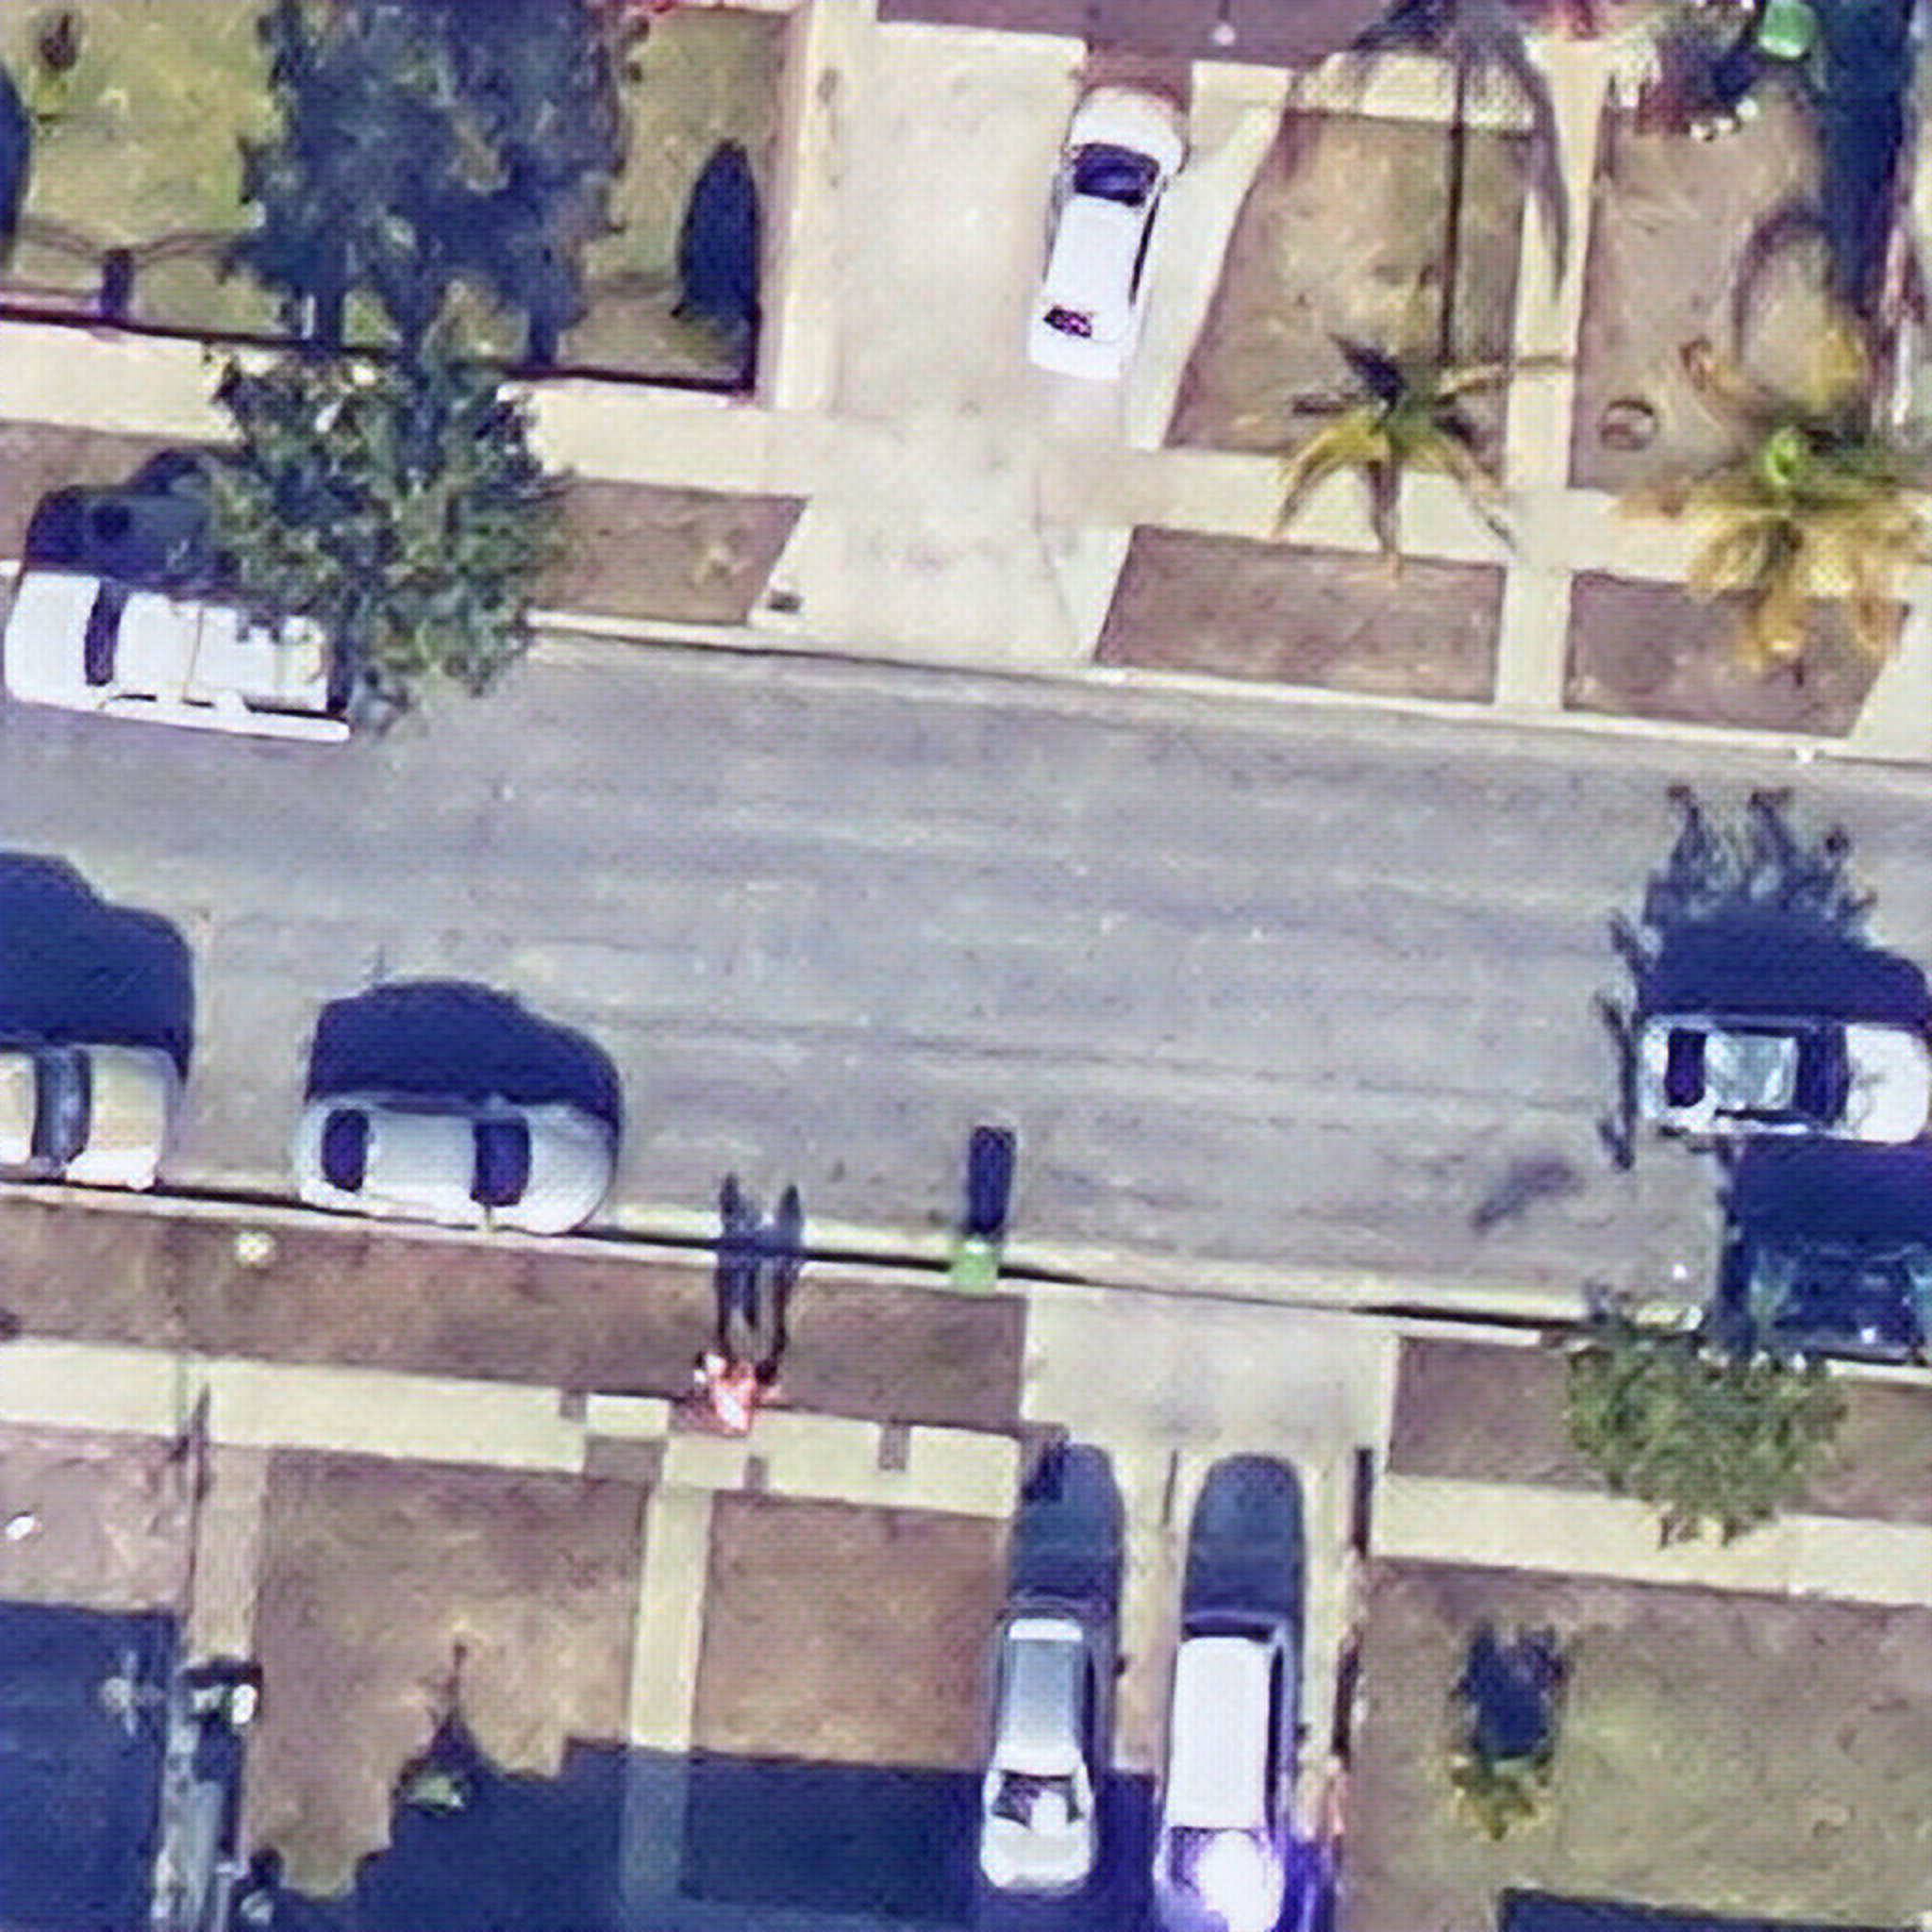

In [47]:
import os

# Update this path to the correct directory on your local machine
image_directory = "./output_images"

# List files in the directory
print(os.listdir(image_directory))

# Display an image from the directory
from IPython.display import Image, display
display(Image(filename=os.path.join(image_directory, 'high_res_generated.png')))
